In [1]:
import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import re
import pandas as pd
import numpy as np

!pip install tokenizers
from tokenizers import SentencePieceBPETokenizer

from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt

from torchtext.data import Field, BPTTIterator
from torchtext.datasets import WikiText2, LanguageModelingDataset

WikiText2.download(root='content')
path = 'content/wikitext-2/wikitext-2'

     |████████████████████████████████| 3.7MB 4.6MB/s 
downloading wikitext-2-v1.zip


wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:00<00:00, 8.65MB/s]


extracting


In [0]:
batch_size = 64
seq_length = 40
SEED = 42
np.random.seed(SEED)

In [66]:
tt.cuda.is_available()

True

In [0]:
device = tt.device('cuda') 

In [0]:
with open(path + '/wiki.train.tokens', 'r') as tr:
  train = tr.read()

with open(path + '/wiki.valid.tokens', 'r') as v:
  val = v.read()

with open(path + '/wiki.test.tokens', 'r') as t:
  test = t.read()


In [0]:
#test

In [0]:
def make_eos(text, eos_old):
  text = re.sub('\s+', ' ', text)
  for sym in eos_old:
    text = text.replace(sym, '<eos> <start>')
  # '<eos> <start> <eos>'  - пустое предложение
  while '<eos> <start> <eos>' in text: # Возможны последовательности оных
    text = text.replace('<eos> <start> <eos>', 'eos')
  return text.strip()

In [0]:
eos_old = ['.', '\n', '!', '?', '…'] # Пришлось запихнуть /n сюда, так как она отделяет мету от связанного текста как сепаратор
tokenizer_test_text = make_eos(test, eos_old)

In [72]:
tokenizer_test_text[:200]

'= Robert <unk> = Robert <unk> is an English film , television and theatre actor <eos> <start> He had a guest @-@ starring role on the television series The Bill in 2000 <eos> <start> This was followed'

In [0]:
tok_train = make_eos(train, eos_old )
with open('content/train.txt', 'w') as tr:
  tr.write(tok_train)

tok_val = make_eos(val, eos_old )
with open('content/val.txt', 'w') as v:
  v.write(tok_val)

tok_test = make_eos(test, eos_old )
with open('content/test.txt', 'w') as t:
  t.write(tok_test)

In [0]:
tokenizer = SentencePieceBPETokenizer()
tokenizer.add_special_tokens(['<eos>', '<start>','<unk>'])
tokenizer.train(['content/val.txt', 'content/train.txt', 'content/test.txt'], vocab_size=20000)

In [75]:
tokenizer.encode("<start> How do you teach a gekkon to code, free of charge <eos> ").tokens

['<start>',
 '▁How',
 '▁do',
 '▁you',
 '▁teach',
 '▁a',
 '▁g',
 'ek',
 'k',
 'on',
 '▁to',
 '▁code',
 ',',
 '▁free',
 '▁of',
 '▁charge',
 '▁',
 '<eos>',
 '▁']

In [76]:
tokenizer.encode(tokenizer_test_text).tokens

['▁=',
 '▁Robert',
 '▁',
 '<unk>',
 '▁=',
 '▁Robert',
 '▁',
 '<unk>',
 '▁is',
 '▁an',
 '▁English',
 '▁film',
 '▁,',
 '▁television',
 '▁and',
 '▁theatre',
 '▁actor',
 '▁',
 '<eos>',
 '▁',
 '<start>',
 '▁He',
 '▁had',
 '▁a',
 '▁guest',
 '▁@-@',
 '▁starring',
 '▁role',
 '▁on',
 '▁the',
 '▁television',
 '▁series',
 '▁The',
 '▁Bill',
 '▁in',
 '▁2000',
 '▁',
 '<eos>',
 '▁',
 '<start>',
 '▁This',
 '▁was',
 '▁followed',
 '▁by',
 '▁a',
 '▁starring',
 '▁role',
 '▁in',
 '▁the',
 '▁play',
 '▁Her',
 'ons',
 '▁written',
 '▁by',
 '▁Simon',
 '▁Step',
 'hens',
 '▁,',
 '▁which',
 '▁was',
 '▁performed',
 '▁in',
 '▁2001',
 '▁at',
 '▁the',
 '▁Royal',
 '▁Court',
 '▁Theatre',
 '▁',
 '<eos>',
 '▁',
 '<start>',
 '▁He',
 '▁had',
 '▁a',
 '▁guest',
 '▁role',
 '▁in',
 '▁the',
 '▁television',
 '▁series',
 '▁Judge',
 '▁John',
 '▁',
 '<unk>',
 '▁in',
 '▁2002',
 '▁',
 '<eos>',
 '▁',
 '<start>',
 '▁In',
 '▁2004',
 '▁',
 '<unk>',
 '▁landed',
 '▁a',
 '▁role',
 '▁as',
 '▁"',
 '▁Craig',
 '▁"',
 '▁in',
 '▁the',
 '▁episode',

Теперь сделаем из этого токенайзер

In [0]:
def my_tokenizer(tokenizer, text, eos_old=['.', '\n', '!', '?', '…']):
  text_eosed = make_eos(text, eos_old)
  return tokenizer.encode(text_eosed).tokens

In [0]:
TEXT = Field(lower=True, tokenize=lambda s: my_tokenizer(tokenizer, s), include_lengths=False, batch_first=True)
trn, vld, tst = WikiText2.splits(TEXT)
TEXT.build_vocab(trn, vld, tst, min_freq=10)

In [0]:
trn_itr, vld_itr, tst_itr = BPTTIterator.splits((trn, vld, tst),
    batch_size=batch_size,
    bptt_len=seq_length, 
    repeat=False,
    device=device)

In [0]:
a = next(iter(trn_itr))
vars(a).keys()

dict_keys(['batch_size', 'dataset', 'fields', 'text', 'target'])

In [0]:
id_to_token = lambda tok_id: TEXT.vocab.itos[tok_id]
token_to_id = lambda tok: TEXT.vocab.stoi[tok]

In [0]:
#def to_text(seq):
  #return [TEXT.vocab.itos[i] for i in seq]

In [0]:
#def join_tok(tok_list): 
  #if tok_list[-1] == '<eos>':
    #return ''.join(tok_list[:-1]).replace('▁', ' ').strip() + ' <eos>'
  #else:
    #return ''.join(tok_list).replace('▁', ' ').strip()

In [0]:
def output(seq):
  t = [TEXT.vocab.itos[i] for i in seq] 
  if t[-1] == '<eos>':
    return ''.join(t[:-1]).replace('▁', ' ').strip() + ' <eos>'
  else:
    return ''.join(t).replace('▁', ' ').strip()

# Модель

In [0]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.rnn = nn.LSTM(input_size=embed_size,
                           hidden_size=hidden_size,
                           bidirectional=True,
                           batch_first=True,
                          )
        
        self.fc = nn.Linear(hidden_size * 2, vocab_size)
        
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, batch):
        
        if hasattr(batch, 'text'):
          x = batch.text.T
        else:
          x = batch
        
        x = self.embedding(x)

            
        x, _ = self.rnn(x)
        
        x = self.fc(x)
        return x.transpose(1,2)

In [0]:
def _train_epoch(model, iterator, optimizer, criterion, curr_epoch):

    model.train()
    train_losses = []
    running_loss = 0

    n_batches = len(iterator)
    iterator = tqdm_notebook(iterator, total=n_batches, desc=f'epoch {curr_epoch + 1}', leave=True)

    for i, batch in enumerate(iterator):
        optimizer.zero_grad()
        pred = model(batch)
        loss = criterion(pred, batch.target.T)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        curr_loss = loss.data.cpu().detach().item()
        
        loss_smoothing = i / (i+1)
        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss

        iterator.set_postfix(loss=f'{running_loss:.5f}')

    return running_loss, train_losses

In [0]:
def _test_epoch(model, iterator, criterion):
    model.eval()
    valid_losses = []
    epoch_loss = 0

    n_batches = len(iterator)
    with tt.no_grad():
      for batch in iterator:
            pred = model(batch)
            loss = criterion(pred, batch.target.T)
            valid_losses.append(loss.item())
            epoch_loss += loss.data.item()

    return epoch_loss / n_batches , valid_losses

In [0]:
def nn_train(model, train_iterator, valid_iterator, criterion, optimizer, n_epochs=100,
          scheduler=None, early_stopping=0):
    model = model.to(device)
    criterion = criterion.to(device)
    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    all_train_losses = []
    all_valid_losses = []

    history = pd.DataFrame()

    for epoch in range(n_epochs):
        train_loss, epoch_train_losses = _train_epoch(model, train_iterator, optimizer, criterion, epoch)
        valid_loss, epoch_valid_losses = _test_epoch(model, valid_iterator, criterion)
        all_train_losses += epoch_train_losses
        all_valid_losses += epoch_valid_losses

        print(f'validation loss {valid_loss:.5f}')

        record = {'epoch': epoch + 1, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print(f"Early stopping! best epoch: {best_epoch['epoch'] + 1} val {best_epoch['valid_loss']:.5f}")
                break

            prev_loss = min(prev_loss, valid_loss)
            
    return history, all_train_losses, all_valid_losses

In [0]:
model = MyModel(vocab_size=len(TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
               )

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

criterion = nn.CrossEntropyLoss(ignore_index=1)

In [0]:
history_df, train_losses, valid_losses = nn_train(model, trn_itr, vld_itr, criterion, optimizer, scheduler=scheduler, 
        n_epochs=10, early_stopping=2)



validation loss 3.32284



validation loss 2.20150



validation loss 1.48965



validation loss 1.00151



validation loss 0.69369



validation loss 0.51034



validation loss 0.39899



validation loss 0.32698



validation loss 0.28222



validation loss 0.25325


In [0]:
model = model.cpu()

In [0]:
def generate(model, fo, max_len=100):
  id_eos = token_to_id('<eos>')
#  id_eos = token_to_id(token_to_id('<eos>'))
  with tt.no_grad():
      tok = token_to_id('<start>')
      seq = [tok]
      i = 0
      while i < max_len and tok != id_eos:
        i += 1
        pred = model(tt.tensor([seq]))[:,:,-1]
        tok = fo(pred)
        seq.append(tok)
  return output(seq)

Для того, чтобы нарисовать графики, я создал датафрейм history_df

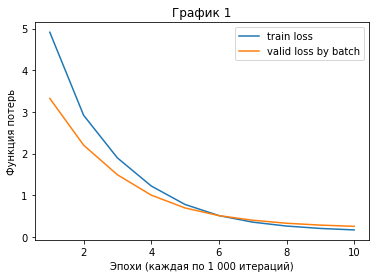

In [0]:
graph = history_df.set_index('epoch')
plt.plot(graph)
plt.xlabel('Эпохи (каждая по 1 000 итераций)')
plt.ylabel('Функция потерь')
plt.title('График 1')
plt.legend(('train loss', 'valid loss by batch'))

# Argmax


In [0]:
argmax = lambda prob: tt.argmax(prob).item()
res = generate(model, argmax)
print (res)

<start> the first time , the first time , the first time , the first time , the first time , the first time , the first time , the first time , the first time , the first time , the first time , the first time , the first time , the first time , the first time , the first time , the first time , the first time , the first time , the first time , the first time , the first time , the first time , the first time , the first time ,


Произошло примерно то, о чём мы говрили на паре: генератор при аргмаксе будет всегда придерживаться примерно одной и той же стратегии, выдавая зацикленный текст. Тут не смысла ждать разнообразия 

# Beamsearch

Так как я до сих пор испытываю неприятные эмоции, когда слышу это слово, я пропущу

# Sampling from probabilty distribution with temperature


In [0]:
def temperature(logits, tau=1):
    logits = logits.detach()
    out = tt.exp(logits/tau)/tt.sum(tt.exp(logits/tau)) 
    out = out.squeeze()
    if np.sum(out.numpy()) != 1:
        return out.numpy()/np.sum(out.numpy())
    else:
        return out.numpy()

In [0]:
def sampling_temperature(logits, tau=1):
    probs = temperature(logits, tau=tau)
    return np.random.choice(len(probs), 1, p=probs)[0]


In [0]:
res = generate(model, sampling_temperature)

print(res)

<start> the church convention considers by urban company , as much back an inspiration <eos> <start> " flash have a high vocals that the one century <eos> <start> the roseberys has also exist seems isolated moving other , guitar stars , biographer <eos> <start> the song in vaudeville species nevertheless , on particular in devon <eos> <start> it volunteered of john zack large scholars ' ( native african ratio <eos> <start> =<eos> <eos> the book or the pictish leased : two under memory areas , caoked behavior


Уже лучше - что-то похоже на настоящий текст...

# Top-k sampling

In [0]:
def top_k(logits, k=0.1):
    logits = logits.detach().squeeze()
    argsorted = tt.argsort(logits, descending=True)

    last = int(np.floor(len(logits) * k))
    if last == 0:
        last = 1

    top_k_ids = argsorted[:last]
    top_k = logits[top_k_ids]
    return top_k, top_k_ids

In [0]:
def sampling_top_k(logits, k=0.2):
    top_k_logits, top_k_ids = top_k(logits, k=k)
    probs = temperature(top_k_logits)
    if len(top_k_ids) == 1:
        return top_k_ids.numpy()[0]
    return np.random.choice(top_k_ids.numpy(), 1, p=probs)[0]

In [0]:
res = generate(model, sampling_top_k, max_len=200)
print(res)

<start> governor was released on the same age <eos> <start> nonetheless , it would not $ them @-@ speaking and sexuality dueful the god were subjected within india , staleying the males be rot to double @-@ <unk>


Однознчный прогресс.

И на этом моменте гугл решил приостановить мне доступ к машинам с GPU за то, что я абьюзил их систем, в связи с чем я, наверное, пойду спать и даже не буду дальше пытаться.

По этой же причине гружу непрокликанный ноутбук.